In [3]:
from typing import Callable, Dict, Iterable, Self
from numpy.typing import NDArray
import datasets
import tensorflow as tf
import numpy as np
import einops
import pandas as pd
import pickle
import sklearn.metrics as skm
import matplotlib.pyplot as plt
import json

import flagon

# Solar Home Dataset

In [68]:
with open("data/solar_home_data.pkl", 'rb') as f:
    data = pickle.load(f)

with open("data/customer_regions.json", 'r') as f:
    customer_regions = json.load(f)

def get_customer_data(customer=1):
    idx = np.arange(24, len(data[customer]))
    expanded_idx = np.array([np.arange(i - 24, i - 1) for i in idx])
    return data[customer][expanded_idx], data[customer][idx, 0]

In [69]:
data_collector_counts = {}
client_ids = {}
for customer, region in customer_regions.items():
    data_collector = region
    if not data_collector_counts.get(data_collector):
        data_collector_counts[data_collector] = 0
    client_ids[f"{data_collector}-{data_collector_counts[data_collector]}"] = int(customer)
    data_collector_counts[data_collector] += 1

In [70]:
class Client(flagon.Client):
    def __init__(self, data, create_model_fn):
        self.data = data
        self.model = create_model_fn()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        history = self.model.fit(self.data['train']['X'], self.data['train']['Y'], epochs=config['num_epochs'])
        return self.model.get_weights(), len(self.data['train']), {k: v[-1] for k, v in history.history.items()}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, mae, rmse = self.model.evaluate(self.data['test']['X'], self.data['test']['Y'])
        return len(self.data['test']), {'loss': loss, 'mean absolute error': mae, 'root mean squared error': rmse}

In [71]:
def create_model() -> tf.keras.Model:
    inputs = tf.keras.Input((23, 4))
    # x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Conv1D(64, 5, activation="relu")(inputs)
    x = tf.keras.layers.Conv1D(64, 3, activation="relu")(x)
    x = tf.keras.layers.Conv1D(32, 2, activation="relu")(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(50, activation="relu")(x)
    x = tf.keras.layers.Dense(1, activation="linear")(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss="mean_squared_error",
        metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()]
    )
    return model

In [76]:
def create_clients(create_model_fn, nclients, seed=None):
    def create_client(client_id: str):
        client_X, client_Y = get_customer_data(client_ids[client_id])
        client_data = {"train": {"X": client_X[:300 * 24], "Y": client_Y[:300 * 24]}, "test": {"X": client_X[300 * 24:], "Y": client_Y[300 * 24:]}}
        return Client(client_data, create_model_fn)
    return create_client

In [ ]:
server = flagon.Server(create_model().get_weights(), {"num_rounds": 1, "num_episodes": 1, "num_epochs": 1})
network_arch = {
    "clients": [{"clients": 0} for _ in data_collector_counts.keys()],
}
for k, v in data_collector_counts.items():
    network_arch['clients'][k]['clients'] = v
flagon.start_simulation(
    server,
    create_clients(create_model, flagon.common.count_clients(network_arch)),
    network_arch
)

In [47]:
X = server.client_manager.clients[0].client_manager.clients[0].data['test']['X']
Y = server.client_manager.clients[0].client_manager.clients[0].data['test']['Y']
model = server.client_manager.clients[0].client_manager.clients[0].model

2/2 [==============================] - 0s 2ms/step


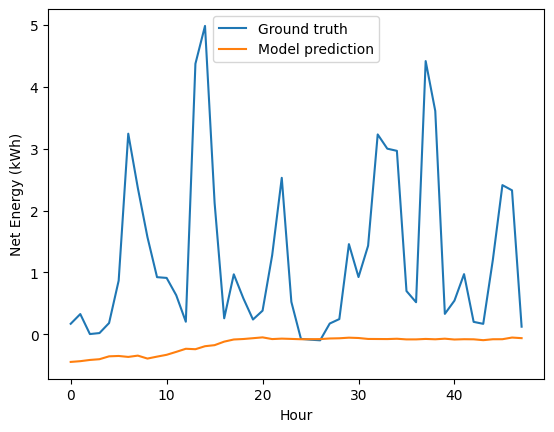

In [48]:
subset_Y = Y[:48]
plt.plot(np.arange(len(subset_Y)), subset_Y, '-', label="Ground truth")

preds = model.predict(X[:48])
plt.plot(np.arange(len(preds)), preds, '-', label="Model prediction")
plt.xlabel("Hour")
plt.ylabel("Net Energy (kWh)")
plt.legend()
plt.show()

# Electricity Consumption Dataset

In [50]:
with open("data/electricity_consumption_2020-2021.pkl", 'rb') as f:
    electricity_con_data = pickle.load(f)

with open("data/central_coast_hunter_weather.pkl", 'rb') as f:
    weather_data = pickle.load(f)

In [51]:
def get_customer_data(lga=0, customer=0):
    idx = np.arange(30, len(electricity_con_data[lga][customer]))
    expanded_idx = np.array([np.arange(i - 30, i - 1) for i in idx])
    return np.concatenate((electricity_con_data[lga][customer, expanded_idx].reshape(-1, 29, 1), weather_data[str(lga)][expanded_idx]), axis=-1), electricity_con_data[lga][customer, idx]

In [52]:
def create_model() -> tf.keras.Model:
    inputs = tf.keras.Input((29, 8))
    # x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Conv1D(64, 5, activation="relu")(inputs)
    x = tf.keras.layers.Conv1D(64, 3, activation="relu")(x)
    x = tf.keras.layers.Conv1D(32, 2, activation="relu")(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(100, activation="relu")(x)
    x = tf.keras.layers.Dense(50, activation="relu")(x)
    x = tf.keras.layers.Dense(1, activation="linear")(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss="mean_squared_error",
        metrics=["mean_absolute_error", tf.keras.metrics.RootMeanSquaredError()]
    )
    return model

In [60]:
def create_clients(create_model_fn, nclients, seed=None):
    def create_client(client_id: str):
        lga = int(client_id[:client_id.find('-')])
        customer = int(client_id[client_id.find('-') + 1:])
        client_X, client_Y = get_customer_data(lga, customer)
        client_data = {"train": {"X": client_X[:300], "Y": client_Y[:300]}, "test": {"X": client_X[300:], "Y": client_Y[300:]}}
        return Client(client_data, create_model_fn)
    return create_client

In [55]:
class Client(flagon.Client):
    def __init__(self, data, create_model_fn):
        self.data = data
        self.model = create_model_fn()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        history = self.model.fit(self.data['train']['X'], self.data['train']['Y'], epochs=config['num_epochs'])
        return self.model.get_weights(), len(self.data['train']), {k: v[-1] for k, v in history.history.items()}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        loss, mae, rmse = self.model.evaluate(self.data['test']['X'], self.data['test']['Y'])
        return len(self.data['test']), {'loss': loss, 'mean absolute error': mae, 'root mean squared error': rmse}

In [67]:
server = flagon.Server(create_model().get_weights(), {"num_rounds": 1, "num_episodes": 1, "num_epochs": 1})
network_arch = {
    "clients": [{"clients": lga_data.shape[0] // 1000} for lga_data in electricity_con_data.values()],
}
flagon.start_simulation(
    server,
    create_clients(create_model, flagon.common.count_clients(network_arch)),
    network_arch
)

KeyError: 96

11/11 [==============================] - 0s 672us/step


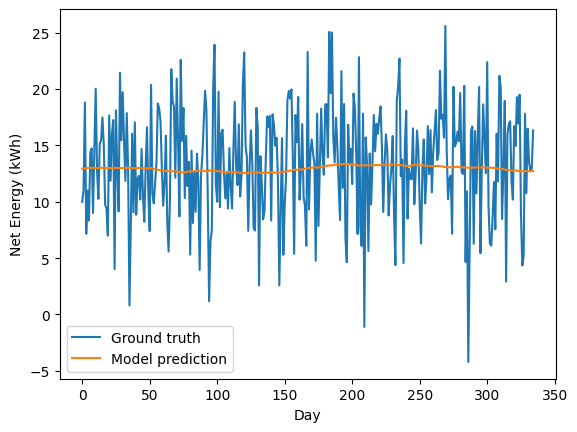

In [62]:
plt.plot(np.arange(len(Y)), Y, '-', label="Ground truth")

preds = model.predict(X)
plt.plot(np.arange(len(preds)), preds, '-', label="Model prediction")
plt.xlabel("Day")
plt.ylabel("Net Energy (kWh)")
plt.legend()
plt.show()